In [1]:
# 先引入必要套件
import jax
import numpy as np
import gcsfs
import neuralgcm
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils

# NeuralGCM: 資料準備

NeuralGCM使用37個氣壓層場的氣象變數作為初始場及預報變數，包含：
- `u_component_of_wind`
- `v_component_of_wind`
- `geopotential`
- `temperature`
- `specific_humidity`
- `specific_cloud_ice_water_content`
- `specific_cloud_liquid_water_content`

除此之外，還使用了兩個表面場作為強迫變數，包含：
- `sea_surface_temperature`
- `sea_ice_cover`

以上資料都是以SI制單位表示，並且均要內插至模式網格點上。

## 將數據重新網格化

若要將ERA5的資料重新網格化，需要經過以下兩個步驟：
1. 下載ERA5的資料
2. 將水平層場重新網格化至地球的高斯座標上。
> 高斯座標是指球面上的經緯網格座標的概念
3. 將缺失的值填補，以確保輸入都是有效的。
> 以`sea_surface_temperature`為例，他只有海洋上的數據，而NeuralGCM的表面模型也包含了一個遮罩，用來忽略了陸地上的數據，但我們仍然需要填補所有的NaN值，以防止它們在計算時洩漏到模型的輸出中。

以下將示範如何使用Dinosaur套件中的工具來進行這兩個操作。

### 讀取預訓練的模型

In [2]:
checkpoint = neuralgcm.demo.load_checkpoint_tl63_stochastic()
model = neuralgcm.PressureLevelModel.from_checkpoint(checkpoint)

### 建立 ERA5 資料

在此建立的ERA5物件並不包含實際的網格值，但當需要取用時就會自動下載。

In [3]:
gcs = gcsfs.GCSFileSystem(token='anon')
path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(path), chunks=None)
full_era5 = full_era5[model.input_variables + model.forcing_variables]

full_era5

<xarray.Dataset> Size: 1PB
Dimensions:                              (time: 1323648, level: 37,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 11MB 1900-01-0...
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 203TB ...
    specific_humidity                    (time, level, latitude, longitude) float32 203TB ...
    temperature                          (time, level, latitude, longitude) float32 203TB ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 203TB ...
    sea_ice_cover                        (time, latitude, longitude) float32 5TB ...
    sea_surface_temperature              (time, latitude, longitude) float32 5TB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

基於預訓練模型以及ERA5資料的網格，我們可以建立一個`Regridder`物件。

In [4]:
# 根據 full_era5 的經緯度資訊建立一個 Grid 物件
full_era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)

# 建立一個 Regridder 物件，他可以用來將 ERA5 資料插值到模型的網格上
regridder = horizontal_interpolation.ConservativeRegridder(
    full_era5_grid, model.data_coords.horizontal, skipna=True
)

regridder

ConservativeRegridder(source_grid=Grid(longitude_wavenumbers=0, total_wavenumbers=0, longitude_nodes=1440, latitude_nodes=721, latitude_spacing='equiangular_with_poles', longitude_offset=0.0, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonics'>, spmd_mesh=None), target_grid=Grid(longitude_wavenumbers=64, total_wavenumbers=65, longitude_nodes=128, latitude_nodes=64, latitude_spacing='gauss', longitude_offset=0.0, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonicsWithZeroImag'>, spmd_mesh=None))

在`ConservativeRegridder`中的`skipna=True`表示，若一個網個包含了NaN和非NaN值，在進行內插計算時應該跳過NaN值。這樣可以確保海表溫度和海冰覆蓋在經過內差後，包含了海岸線的低解析度網格依舊有合理的值。

從全體的ERA5資料中，選擇一個我們需要的時間點，以2020年1月1日為例。

In [5]:
sliced_era5 = full_era5.sel(time='2020-01-01T00').compute()  # xarray的機制是當真的需要使用資料時才會計算，但如果加上compute()則會強迫他立即計算並取得結果

sliced_era5

<xarray.Dataset> Size: 1GB
Dimensions:                              (level: 37, latitude: 721,
                                          longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
    time                                 datetime64[ns] 8B 2020-01-01
Data variables:
    geopotential                         (level, latitude, longitude) float32 154MB ...
    specific_humidity                    (level, latitude, longitude) float32 154MB ...
    temperature                          (level, latitude, longitude) float32 154MB ...
    u_component_of_wind                  (level, latitude, longitude) float32 154MB ...
    v_component_of_wind                  (level, latitude, longitude) float32 154MB ...
    specific_cloud_ice_water_content     (level, latitude, longitude) float32 154MB ...
    specific_cloud_liquid_water_content  (level, latitude, longitude) float32 154MB ...
    sea_ice_cover                        (latitude, longitude) float32 4MB 1....
    sea_surface_temperature              (latitude, longitude) float32 4MB 27...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

### 將 ERA5 資料重新網格化

In [6]:
regridded = xarray_utils.regrid(sliced_era5, regridder)

regridded

<xarray.Dataset> Size: 9MB
Dimensions:                              (level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * level                                (level) int64 296B 1 2 3 ... 975 1000
    time                                 datetime64[ns] 8B 2020-01-01
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
Data variables:
    geopotential                         (level, longitude, latitude) float32 1MB ...
    specific_humidity                    (level, longitude, latitude) float32 1MB ...
    temperature                          (level, longitude, latitude) float32 1MB ...
    u_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    v_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 1MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 1MB ...
    sea_ice_cover                        (longitude, latitude) float32 33kB n...
    sea_surface_temperature              (longitude, latitude) float32 33kB n...

以下為原始資料與重新網格化後的資料的比較。

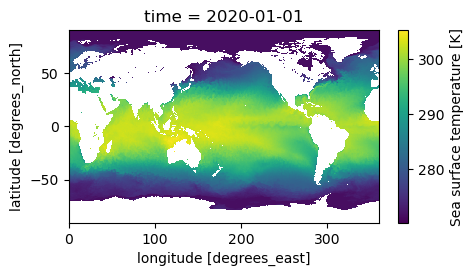

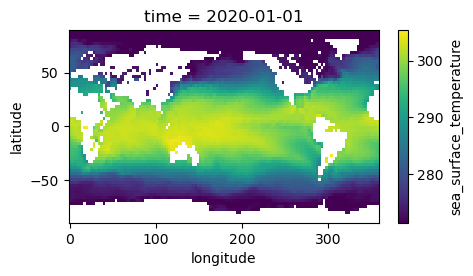

In [7]:
sliced_era5.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5)
regridded.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5)

### 填補缺失的值

然而目前的資料中還有一些缺失的值，我們需要利用各網格最鄰近的非缺失值

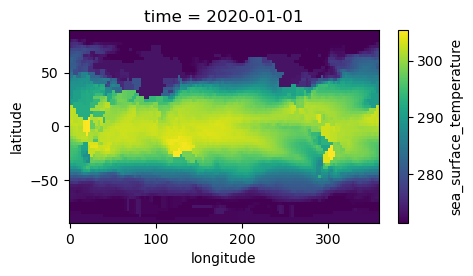

In [8]:
regridded_and_filled = xarray_utils.fill_nan_with_nearest(regridded)

regridded_and_filled.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

## 以Xarray格式進行輸入與輸出

NeuralGCM的模型輸入可以接受字典格式的數據，例如

```python
inputs = {
    'u_component_of_wind': u_component_of_wind,
    'v_component_of_wind': v_component_of_wind,
    'geopotential': geopotential,
    ...
}
```

但是我們主要還是會利用Xarray來作為輸入，因此我們需要將Xarray數據轉換為字典格式。

In [9]:
# 讓model.inputs_from_xarray()自動從Xarray物件中提取模型所需的預報變數，並以字典返回
inputs = model.inputs_from_xarray(regridded_and_filled)
# 讓model.forcings_from_xarray()自動從Xarray物件中提取模型所需的強迫變數，並以字典返回
forcings = model.forcings_from_xarray(regridded_and_filled)

# 以inputs為例展示轉換後的結果
inputs

{'geopotential': array([[[ 4.9305119e+05,  4.9281669e+05,  4.9248794e+05, ...,
           4.2202688e+05,  4.2354853e+05,  4.2598703e+05],
         [ 4.9304959e+05,  4.9281319e+05,  4.9246266e+05, ...,
           4.2201378e+05,  4.2356706e+05,  4.2597228e+05],
         [ 4.9304884e+05,  4.9280950e+05,  4.9243981e+05, ...,
           4.2200138e+05,  4.2359141e+05,  4.2596366e+05],
         ...,
         [ 4.9306038e+05,  4.9282588e+05,  4.9253734e+05, ...,
           4.2201681e+05,  4.2354159e+05,  4.2607175e+05],
         [ 4.9305641e+05,  4.9282275e+05,  4.9252575e+05, ...,
           4.2203122e+05,  4.2353309e+05,  4.2603647e+05],
         [ 4.9305338e+05,  4.9281953e+05,  4.9250997e+05, ...,
           4.2203416e+05,  4.2353716e+05,  4.2600831e+05]],
 
        [[ 4.3545066e+05,  4.3527394e+05,  4.3502753e+05, ...,
           3.7041806e+05,  3.7218562e+05,  3.7458788e+05],
         [ 4.3544572e+05,  4.3526412e+05,  4.3500553e+05, ...,
           3.7032141e+05,  3.7210106e+05,  3.74536

我們可以查看各個預報變數的維度

In [10]:
jax.tree.map(np.shape, inputs)

{'geopotential': (37, 128, 64),
 'sim_time': (),
 'specific_cloud_ice_water_content': (37, 128, 64),
 'specific_cloud_liquid_water_content': (37, 128, 64),
 'specific_humidity': (37, 128, 64),
 'temperature': (37, 128, 64),
 'u_component_of_wind': (37, 128, 64),
 'v_component_of_wind': (37, 128, 64)}

以及各個強迫變數的維度

In [11]:
jax.tree.map(np.shape, forcings)

{'sea_ice_cover': (1, 128, 64),
 'sea_surface_temperature': (1, 128, 64),
 'sim_time': ()}

可以發現：
- 預報變數的維度是`(高度層數, 經向網格數, 緯向網格數)`
- 強迫變數的維度是`(1, 經向網格數, 緯向網格數)`，因為只有最表層的一層數據。
- sim_time表示此時的時間，用來計算當下的入射輻射，也因此他只是一個時間點並無維度。

針對時間的部分，考慮到JAX並不支援NumPy的datetime64數據類型，因此模型會自動的將時間轉為一個無量綱的數字，以便於計算。若要將datetime64轉為無量綱的數字，可以使用以下的函數：

In [12]:
time_dt64 = regridded_and_filled.time.data  # array('2020-01-01T00:00:00')
model.datetime64_to_sim_time(time_dt64)

188693.6256

模式的輸出可以被轉換為Xarray格式，以便於進行後續的分析。

In [13]:
model.data_to_xarray(
    model.inputs_from_xarray(regridded_and_filled),
    times=None,  # times=None indicates no leading time-axis
)

<xarray.Dataset> Size: 8MB
Dimensions:                              (level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
  * level                                (level) int64 296B 1 2 3 ... 975 1000
Data variables:
    v_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    u_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    specific_humidity                    (level, longitude, latitude) float32 1MB ...
    geopotential                         (level, longitude, latitude) float32 1MB ...
    temperature                          (level, longitude, latitude) float32 1MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 1MB ...
    sim_time                             float64 8B 1.887e+05
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 1MB ...
Attributes:
    longitude_wavenumbers:     64
    total_wavenumbers:         65
    longitude_nodes:           128
    latitude_nodes:            64
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

> 注意：原則上，`neuralgcm.PressureLevelModel.simtime_to_datetime64` 可以自動計算輸出時間（例如，從 `neuralgcm.PressureLevelModel.unroll` 的輸出），但這不是推薦的。默認情況下，JAX 以 float32 模式進行數學運算，這可能會導致顯著的四捨五入誤差（例如，最多幾分鐘）。如 {doc}`inference_demo` 所示，我們建議直接使用 NumPy 或 pandas 計算時間。

## 時間偏移

由於強迫項會依據距離正在模擬的時間點來最接近的時間點來取值，例如：

模式目前是14:00，我們正在模擬15:00的大氣狀況（積分時步是1小時），那按理來說我們會需要投入14:00的強迫項，不過如果只有每天的00:00有強迫項的資料，那模式會取最鄰近的時間點（也就是隔日00:00）的強迫項作為本次積分的強迫項。

為了避免有人質疑使用的強迫項包含了未來的資訊，我們可以將強迫項的時間偏移一天，確保絕對不會使用到未來的資訊來進行積分。

我們可以使用`xarray_utils.selective_temporal_shift`來進行時間偏移，不手動偏移的原因是，如果使用xarray，我們可以用到其「需要時才載入」的特性，即使資料量很大也不會將資料全部讀入記憶體，造成記憶體空間的過度佔用。

In [16]:
xarray_utils.selective_temporal_shift(
    dataset=full_era5,
    variables=model.forcing_variables,
    time_shift='24 hours',  # 會發現以下的資料變成從1900-01-02開始
)

<xarray.Dataset> Size: 1PB
Dimensions:                              (time: 1323624, level: 37,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 11MB 1900-01-0...
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 203TB ...
    specific_humidity                    (time, level, latitude, longitude) float32 203TB ...
    temperature                          (time, level, latitude, longitude) float32 203TB ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 203TB ...
    sea_ice_cover                        (time, latitude, longitude) float32 5TB ...
    sea_surface_temperature              (time, latitude, longitude) float32 5TB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31